# Aaron Tan
## Mini Project 2 - Lung Cancer Detection

#### Import all the python libraries required for this project

In [94]:
# === Core scientific stack ===
import numpy as np
import pandas as pd
from scipy import stats

# === Plotting ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Utilities / IO ===
import requests
from IPython.display import display, clear_output

# === Mapping (optional) ===
import folium
from folium.plugins import HeatMap

from sklearn.calibration import CalibratedClassifierCV

# === Scikit-learn ===
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector

# === Models packages ===
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone

# === Models packages (ensemble) ===
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# === Evaulation ML ===
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, roc_auc_score, 
    balanced_accuracy_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer

import pickle, json, time, platform, sklearn

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

## 1. Load CSV Data and EDA Analysis
Begin by loading the dataset and conducting Exploratory Data Analysis (EDA) to understand the features, their distributions, and relationships. The goal is to identify which variables are most relevant and how they may influence or predict cancer risk.

Reference from: https://www.kaggle.com/datasets/jillanisofttech/lung-cancer-detection/data

### About This Dataset
This dataset contains survey-based medical data of 309 individuals with 15 health and lifestyle features (such as smoking, coughing, fatigue, and chest pain) used to predict whether a person is at risk of lung cancer.

In [95]:
cancer_csv = "survey_lung_cancer.csv"
df = pd.read_csv(cancer_csv)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [96]:
df.columns

Index(['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER'],
      dtype='object')

### 1.1 Column Descriptions:

15 Features:
- GENDER – Gender of the participant (Male = 1, Female = 0).
- AGE – Age of the participant in years.
- SMOKING – Whether the person smokes or has a smoking history.
- YELLOW_FINGERS – Presence of yellowing fingers (often linked with heavy smoking).
- ANXIETY – Whether the participant experiences anxiety.
- PEER_PRESSURE – Influence of peers encouraging smoking or related habits.
- CHRONIC_DISEASE – Presence of any chronic illness (e.g., COPD, asthma).
- FATIGUE – Whether the participant frequently feels tired or fatigued.
- ALLERGY – Whether the participant has any allergies.
- WHEEZING – Presence of wheezing or breathing difficulties.
- ALCOHOL_CONSUMING – Whether the participant consumes alcohol.
- COUGHING – Presence of a persistent cough.
- SHORTNESS_OF_BREATH – Frequency of breathlessness during daily activity.
- SWALLOWING_DIFFICULTY – Trouble swallowing, possibly due to throat or lung issues.
- CHEST_PAIN – Reports of chest pain or tightness.

Predict variable:
- LUNG_CANCER – The target label indicating lung cancer diagnosis status:
    -   YES → High likelihood or presence of lung cancer
    -   NO → No signs of lung cancer


In [97]:
df.shape

(309, 16)

In [98]:
print(df.describe())

              AGE     SMOKING  YELLOW_FINGERS     ANXIETY  PEER_PRESSURE  \
count  309.000000  309.000000      309.000000  309.000000     309.000000   
mean    62.673139    1.563107        1.569579    1.498382       1.501618   
std      8.210301    0.496806        0.495938    0.500808       0.500808   
min     21.000000    1.000000        1.000000    1.000000       1.000000   
25%     57.000000    1.000000        1.000000    1.000000       1.000000   
50%     62.000000    2.000000        2.000000    1.000000       2.000000   
75%     69.000000    2.000000        2.000000    2.000000       2.000000   
max     87.000000    2.000000        2.000000    2.000000       2.000000   

       CHRONIC DISEASE    FATIGUE     ALLERGY     WHEEZING  ALCOHOL CONSUMING  \
count       309.000000  309.000000  309.000000  309.000000         309.000000   
mean          1.504854    1.673139    1.556634    1.556634           1.556634   
std           0.500787    0.469827    0.497588    0.497588           0.4

Check if there is any NAs or outliers

In [99]:
# Count missing values in each column
# For this case, lucky there is no NAs
print(df.isna().sum())

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64


Data Clean column names to be consistent

In [100]:
# --- 1️⃣ Clean column names ---
df.columns = (
    df.columns
    .str.strip()
    .str.replace("_", " ", regex=False)
    .str.replace("  +", " ", regex=True)
)

# --- 2️⃣ Gender to numeric ---
df["GENDER"] = df["GENDER"].map({"M": 1, "F": 0})

# --- 3️⃣ Convert 1/2 encoding to 0/1 ---
# These are your yes/no-style columns
yes_no_cols = [
    "SMOKING", "YELLOW FINGERS", "ANXIETY", "PEER PRESSURE",
    "CHRONIC DISEASE", "FATIGUE", "ALLERGY", "WHEEZING",
    "ALCOHOL CONSUMING", "COUGHING", "SHORTNESS OF BREATH",
    "SWALLOWING DIFFICULTY", "CHEST PAIN"
]

# Map 1 → 0 (No), 2 → 1 (Yes)
for col in yes_no_cols:
    df[col] = df[col].replace({1: 0, 2: 1})

# --- 4️⃣ Target variable: LUNG_CANCER (Yes/No to 1/0) ---
df["LUNG CANCER"] = df["LUNG CANCER"].replace({"YES": 1, "NO": 0})

# --- 5️⃣ Verify ---
print(df.head(3))
print(df.dtypes)

   GENDER  AGE  SMOKING  YELLOW FINGERS  ANXIETY  PEER PRESSURE  \
0       1   69        0               1        1              0   
1       1   74        1               0        0              0   
2       0   59        0               0        0              1   

   CHRONIC DISEASE  FATIGUE  ALLERGY  WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                0        1        0         1                  1         1   
1                1        1        1         0                  0         0   
2                0        1        0         1                  0         1   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN  LUNG CANCER  
0                    1                      1           1            1  
1                    1                      1           1            1  
2                    1                      0           1            0  
GENDER                   int64
AGE                      int64
SMOKING                  int64
YELLOW FINGERS           int6

## 2. Classification Modeling and Evaluation

Now we are at the stage to perform the following sub-sections:
- Feature Selection 
- Train and Test Split dataset
- Preprocessing
- Model Selection (Supervised Models)
    - Simple Base line Models
    - Ensemble Models

#### 2.1 Feature Selection  
The dataset is divided into independent variables (**X**) that serve as predictors and the dependent variable (**y**) that represents the outcome to be classified.  

##### Note on Forward Feature Selection:
Forward feature selection will not be applied in this project. While it can help identify subsets of features that improve predictive performance, it is also computationally expensive, requires repeated model training, and may overfit to small datasets by exploiting chance correlations. Given that the dataset here is relatively straightforward and the number of features is manageable, it is more effective to retain all predictors and instead rely on regularization (within models such as Logistic Regression, SVM, or tree-based methods) and cross-validation to handle feature relevance automatically. This ensures a balance between interpretability, efficiency, and generalization.

In this case, the target variable **LUNG_CANCER** is a **binary classification** label with two categories:  
1. **YES** – High likelihood or presence of lung cancer
2. **NO** - No signs of lung cancer 

In [101]:
# X represents the features or columns. Exclude the predict variable.
X = df.drop(columns=["LUNG CANCER"])
y = df["LUNG CANCER"]


print("X columns:", X.columns.tolist())

# Identify numeric & categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

print("X features variables:")
print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

print("\nY predictor variable:")
print("Target column:", y.name)

X columns: ['GENDER', 'AGE', 'SMOKING', 'YELLOW FINGERS', 'ANXIETY', 'PEER PRESSURE', 'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']
X features variables:
Numeric columns: ['GENDER', 'AGE', 'SMOKING', 'YELLOW FINGERS', 'ANXIETY', 'PEER PRESSURE', 'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']
Categorical columns: []

Y predictor variable:
Target column: LUNG CANCER


#### 2.2 Train and Test Split dataset

In [102]:
# 1. Split the dataset into training and testing sets (80/20 split).
# 'stratify=y' ensures the class distribution is preserved in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

print("\nClass balance (train):")
print(y_train.value_counts(normalize=True).round(3))
print("\nClass balance (test):")
print(y_test.value_counts(normalize=True).round(3))

Training set shape: (247, 15)
Testing set shape: (62, 15)

Class balance (train):
LUNG CANCER
1    0.874
0    0.126
Name: proportion, dtype: float64

Class balance (test):
LUNG CANCER
1    0.871
0    0.129
Name: proportion, dtype: float64


#### 2.3 Preprocessing
Before training the model, the dataset needs to be cleaned and transformed into a format suitable for machine learning algorithms.
This is achieved by creating separate pipelines for numeric and categorical features and combining them using a ColumnTransformer.

In [103]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

#### 2.4 Model Selection (Supervised Models)

1.	Simple Baseline Models:
-	Logistic Regression
-	Naïve Bayes
-	KNN
-	Decision Tree
-   SVM

2.	Ensemble Models
- Random Forest
- Extra Trees
- Bagging (Decision Trees)
- AdaBoost
- Gradient Boosting
- HistGradientBoosting
- Voting (Soft)
- Stacking

#### 🧩 2.4.1 Simple Baseline Models

These baseline models serve as the **first comparison point** before using more complex or ensemble methods.  
They help establish how well straightforward algorithms perform on the dataset, offering interpretability and speed for initial benchmarking.

| Model | Description | Strengths | Limitations |
|:------|:-------------|:-----------|:-------------|
| **Logistic Regression** | A linear classifier that models class probabilities using a logistic (sigmoid) function. Often used for both binary and multiclass classification (`multinomial`). | Interpretable coefficients, efficient, good with linearly separable data. | Struggles with non-linear relationships. |
| **Naïve Bayes** | A probabilistic model based on Bayes’ Theorem, assuming independence between features. | Very fast, works well with small data and text features. | Independence assumption is often unrealistic; limited capacity for complex patterns. |
| **K-Nearest Neighbors (KNN)** | A non-parametric, instance-based learner that classifies a sample by majority vote of its nearest neighbors. | Simple to understand, no training phase. | Computationally heavy on large datasets; sensitive to feature scaling. |
| **Decision Tree** | A rule-based model that recursively splits data into branches based on feature thresholds to maximize information gain. | Handles non-linear data and interactions well; interpretable structure. | Prone to overfitting without depth control or pruning. |
| **SVM (Support Vector Machine)** | A powerful supervised model that finds the optimal hyperplane that maximizes the margin between classes. Can use kernels (e.g., RBF, polynomial) to handle non-linear decision boundaries | Works well in high-dimensional spaces; effective when classes are well-separated; robust to overfitting with proper regularization. | Computationally expensive on large datasets; sensitive to choice of kernel and hyperparameters. |

> 🧠 **Purpose:**  
> These models form a simple yet diverse foundation—covering **linear**, **probabilistic**, **instance-based**, and **tree-based** paradigms—to assess baseline performance before tuning or ensemble experimentation (e.g., Random Forests, Gradient Boosting).


In [104]:
models = {
    # 1️⃣ Logistic Regression — tuned for binary classification
    "LogReg": Pipeline([
        ("pre", pre),
        ("clf", LogisticRegression(
            solver="lbfgs",
            C=2.0,                   # slightly less regularization
            class_weight="balanced", # handle class imbalance
            penalty="l2",
            max_iter=3000,
            random_state=42
        ))
    ]),

    # 2️⃣ Gaussian Naive Bayes — simple probabilistic baseline
    "GaussianNB": Pipeline([
        ("pre", pre),
        ("clf", GaussianNB(var_smoothing=1e-8))
    ]),

    # 3️⃣ KNN — distance-weighted voting
    "KNN": Pipeline([
        ("pre", pre),
        ("clf", KNeighborsClassifier(
            n_neighbors=7,
            weights="distance",
            p=2
        ))
    ]),

    # 4️⃣ Decision Tree — pruned for generalization
    "DecisionTree": Pipeline([
        ("pre", pre),
        ("clf", DecisionTreeClassifier(
            criterion="entropy",
            max_depth=8,
            min_samples_leaf=3,
            class_weight="balanced",
            random_state=42
        ))
    ]),

    # 5️⃣ SVM — RBF kernel, tuned for margin accuracy
    "SVM": Pipeline([
        ("pre", pre),
        ("clf", SVC(
            kernel="rbf",
            C=3.0,
            gamma="scale",
            class_weight="balanced",
            probability=True,
            random_state=42
        ))
    ])
}


In [105]:
# 2) Fit, predict, store results
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # all four support predict_proba for multiclass
    y_prob = pipe.predict_proba(X_test)

    results[name] = {
        "pipe": pipe,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

#### ROC and Evaulation Metrics for all Baseline Models

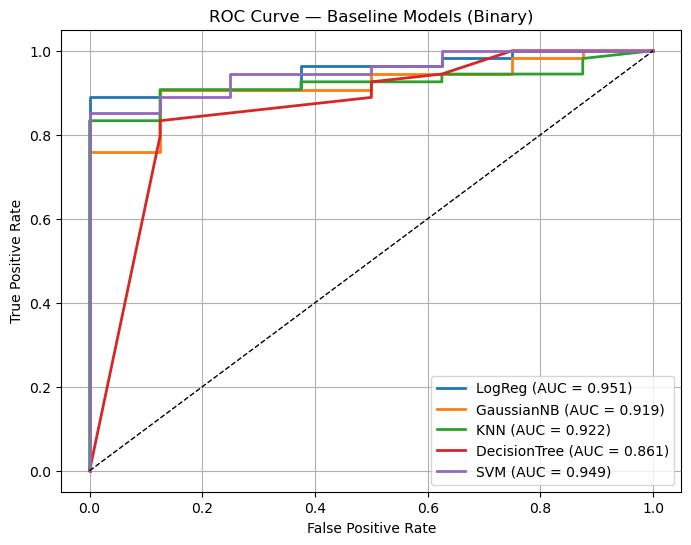

,Model,Accuracy,Balanced Acc,Precision (w),Recall (w),F1 (w),AUC
0,LogReg,0.871,0.926,0.935,0.871,0.887,0.951
1,DecisionTree,0.806,0.836,0.901,0.806,0.834,0.861
2,SVM,0.871,0.819,0.901,0.871,0.881,0.949
3,GaussianNB,0.855,0.704,0.863,0.855,0.858,0.919
4,KNN,0.855,0.650,0.847,0.855,0.851,0.922


In [106]:
# === Evaluation Metrics + AUC ===
rows = []

plt.figure(figsize=(8, 6))

for name, res in results.items():
    model = res["pipe"]
    y_pred = res["y_pred"]
    y_prob = res["y_prob"]   # expected to be either (n,2) from predict_proba or (n,) from decision_function

    # --- pick positive-class scores consistently ---
    classes_ = getattr(model, "classes_", None)
    if classes_ is None:
        # try to get from final estimator in the pipeline
        classes_ = model.named_steps[next(reversed(model.named_steps))].classes_

    # define positive label as the second class (sklearn’s convention after sorting)
    pos_label = classes_[1]

    # probabilities -> take column for positive class; otherwise use decision scores as-is
    if y_prob.ndim == 2:
        # column index for the positive class
        pos_idx = list(classes_).index(pos_label)
        y_score = y_prob[:, pos_idx]
    else:
        # already 1D (e.g., decision_function)
        y_score = y_prob

    # binarize y_test as 0/1 with the same positive label
    y_true_bin = (np.asarray(y_test) == pos_label).astype(int)

    # core metrics
    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    # ROC/AUC for binary
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    auc_overall = roc_auc_score(y_true_bin, y_score)

    rows.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Balanced Acc": round(bacc, 3),
        "Precision (w)": round(prec_w, 3),
        "Recall (w)": round(rec_w, 3),
        "F1 (w)": round(f1_w, 3),
        "AUC": round(auc_overall, 3),
    })

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_overall:.3f})")

# --- Plot ROC for all models ---
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve — Baseline Models (Binary)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Table with ranking ---
# Create and sort metrics DataFrame (same as before)
metrics_df = (
    pd.DataFrame(rows)
    .sort_values(by=["Balanced Acc", "AUC"], ascending=False)
    .reset_index(drop=True)
)

# Format numbers to 3 decimals and align columns
styled_df = (
    metrics_df.style
    .set_caption("📊 Simple Baseline Models Metric Results")
    .format({
        "Accuracy": "{:.3f}",
        "Balanced Acc": "{:.3f}",
        "Precision (w)": "{:.3f}",
        "Recall (w)": "{:.3f}",
        "F1 (w)": "{:.3f}",
        "AUC": "{:.3f}",
    })
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "14px"), ("text-align", "left"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
)

styled_df


#### 5 Cross-Fold Validation

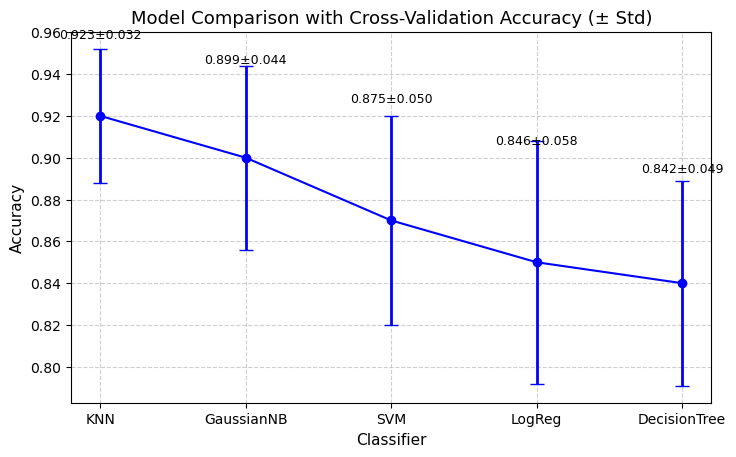

5 Cross-Validation Results Summary:

       Model  Lowest %  Mean Accuracy  Highest %  Variance ± by %  Rank
         KNN      0.89         0.9231       0.96             0.06     1
  GaussianNB      0.85         0.8988       0.94             0.09     2
         SVM      0.82         0.8747       0.92             0.10     3
      LogReg      0.79         0.8463       0.90             0.12     4
DecisionTree      0.79         0.8420       0.89             0.10     5


In [107]:
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Cross-validation to compute mean ± std ===
mean_scores = []
std_scores = []
model_names = list(models.keys())

for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# === Create a DataFrame for summary table ===
summary_df = pd.DataFrame({
    "Model": model_names,
    "Mean Accuracy": np.round(mean_scores, 4),
    "Std Dev": np.round(std_scores, 4)
}).sort_values(by="Mean Accuracy", ascending=False).reset_index(drop=True)

summary_df["Rank"] = np.arange(1, len(summary_df) + 1)

# === Plot figure with two sections: chart + table ===
fig, ax = plt.subplots(figsize=(8, 7))

# --- Error bar plot ---
ax.errorbar(
    summary_df["Model"],
    summary_df["Mean Accuracy"].round(2),
    yerr=summary_df["Std Dev"],
    fmt='o-', color='blue', ecolor='blue',
    elinewidth=2, capsize=5, markersize=6
)

# --- Chart labels ---
ax.set_title("Model Comparison with Cross-Validation Accuracy (± Std)", fontsize=13)
ax.set_xlabel("Classifier", fontsize=11)
ax.set_ylabel("Accuracy", fontsize=11)
ax.grid(True, linestyle="--", alpha=0.6)

# --- Annotate each point with mean ± std ---
for i, row in summary_df.iterrows():
    ax.text(i, row["Mean Accuracy"] + row["Std Dev"] + 0.002,
            f"{row['Mean Accuracy']:.3f}±{row['Std Dev']:.3f}",
            ha='center', fontsize=9, color='black')



# Adjust layout to make room for the table
plt.subplots_adjust(left=0.1, bottom=0.35)

plt.show()

# --- Also print the table cleanly in text output ---
# Assume you already have summary_df with columns: Model, Mean Accuracy, Std Dev, Rank
summary_df["Lowest %"]   = (summary_df["Mean Accuracy"] - summary_df["Std Dev"]).round(2)
summary_df["Highest %"]  = (summary_df["Mean Accuracy"] + summary_df["Std Dev"]).round(2)
summary_df["Variance ± by %"] = (2 * summary_df["Std Dev"]).round(2)

# Reorder columns and drop Std Dev
summary_df = summary_df[["Model", "Lowest %", "Mean Accuracy", "Highest %", "Variance ± by %", "Rank"]]

print("5 Cross-Validation Results Summary:\n")
print(summary_df.to_string(index=False))

#### Confusion Matrix and Classification Report for Logistic Regression


🏆 Confusion Matrix & Report for Best Model (by AUC): LogReg

Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       1.00      0.85      0.92        54

    accuracy                           0.87        62
   macro avg       0.75      0.93      0.79        62
weighted avg       0.94      0.87      0.89        62

X number of training (80% training split): 247
X number of samples (20% test split): 62


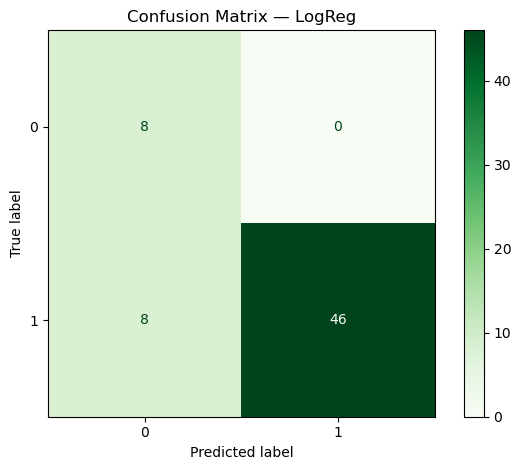

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1) Pick the best model (by AUC; change to "Balanced Acc" if you prefer)
best_model_name = metrics_df.loc[metrics_df["AUC"].idxmax(), "Model"]
best_model      = results[best_model_name]["pipe"]
best_y_pred     = results[best_model_name]["y_pred"]

# 2) Classification report
print(f"\n🏆 Confusion Matrix & Report for Best Model (by AUC): {best_model_name}\n")
print("Classification report:")
print(classification_report(y_test, best_y_pred, zero_division=0))

# 3) Confusion matrix (matplotlib)
cm = confusion_matrix(y_test, best_y_pred)
labels = (best_model.classes_ 
          if hasattr(best_model, "classes_") 
          else best_model.named_steps[list(best_model.named_steps.keys())[-1]].classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Greens", values_format="d")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.tight_layout()
print("X number of training (80% training split):", X_train.shape[0])
print("X number of samples (20% test split):", X_test.shape[0])
plt.show()

#### Show Pie chart

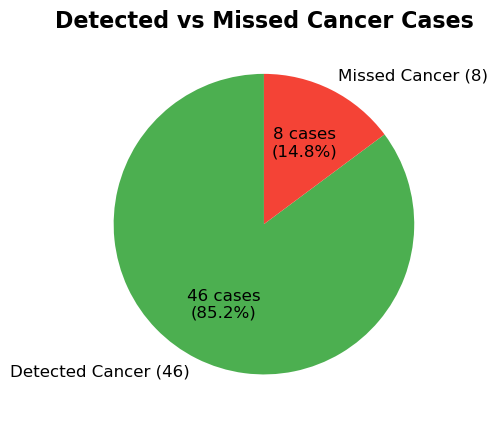

In [109]:
# 4️⃣ Pie Chart — Detected vs Missed Cancer (for easy audience understanding)
tp = cm[1, 1]  # True Positives
fn = cm[1, 0]  # False Negatives

labels_pie = [f"Detected Cancer ({tp})", f"Missed Cancer ({fn})"]
values = [tp, fn]
colors = ["#4CAF50", "#F44336"]

plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(
    values,
    labels=labels_pie,
    autopct=lambda p: f"{int(round(p*sum(values)/100))} cases\n({p:.1f}%)",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 12, "color": "black"}
)
plt.title("Detected vs Missed Cancer Cases", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

#### Showcase AUC Curve for Logistic Regression

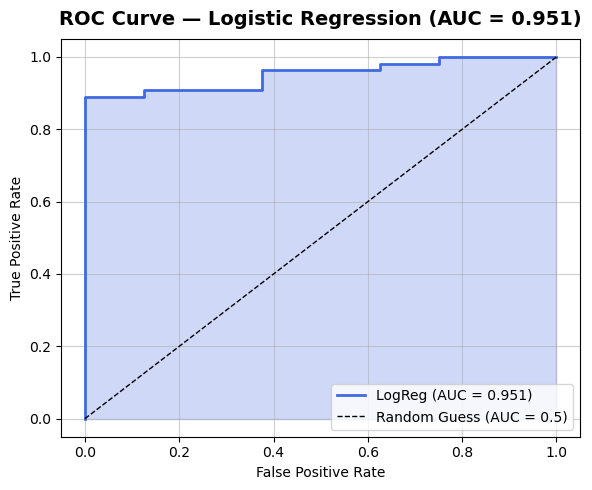

In [110]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Pick only Logistic Regression model ---
logreg_model = results["LogReg"]["pipe"]
y_prob = results["LogReg"]["y_prob"]

# Ensure correct positive class
classes_ = getattr(logreg_model, "classes_", None)
if classes_ is None:
    classes_ = logreg_model.named_steps[next(reversed(logreg_model.named_steps))].classes_
pos_label = classes_[1]
if y_prob.ndim == 2:
    pos_idx = list(classes_).index(pos_label)
    y_score = y_prob[:, pos_idx]
else:
    y_score = y_prob

# True labels as binary
y_true_bin = (np.asarray(y_test) == pos_label).astype(int)

# --- Compute ROC curve and AUC ---
fpr, tpr, _ = roc_curve(y_true_bin, y_score)
auc_value = roc_auc_score(y_true_bin, y_score)

# --- Plot with filled AUC area ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="royalblue", lw=2, label=f"LogReg (AUC = {auc_value:.3f})")
plt.fill_between(fpr, tpr, color="royalblue", alpha=0.25)  # highlight AUC area
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random Guess (AUC = 0.5)")

plt.title(f"ROC Curve — Logistic Regression (AUC = {auc_value:.3f})",
          fontsize=14, fontweight="bold", pad=10)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()


#### 🧩  2.4.2 Ensemble Models

Ensemble models combine multiple individual (often weak) learners to create a stronger, more robust predictive model.  
Unlike single models that rely on one decision boundary, ensembles aggregate the knowledge of many models to reduce bias, variance, and overfitting — typically achieving superior performance on structured/tabular data.

| Model | Description | Strengths | Limitations |
|:------|:-------------|:-----------|:-------------|
| **Random Forest** | A bagging ensemble of Decision Trees built on random subsets of data and features. | Reduces overfitting, handles non-linear data, robust to noise and outliers. | Can be computationally expensive; less interpretable than single trees. |
| **Gradient Boosting** | Sequentially builds trees where each one corrects the errors of the previous. | Achieves high predictive accuracy, handles mixed data types well. | Sensitive to hyperparameters; slower to train. |
| **Extra Trees** | “Extremely randomized trees”: like Random Forest but with randomly chosen split thresholds. | Very fast, low variance, good on high-dimensional tabular data.| Higher bias than RF, can underfit; poorer probability calibration. |
| **Bagging (Decision Trees)** | Many Decision Trees trained on bootstrap samples; predictions averaged. | Strong variance reduction; robust to overfitting; trivially parallelizable.| Bias of base learner remains; can be outperformed by boosted methods. |
| **AdaBoost** | Reweights misclassified samples iteratively; here with shallow trees and SAMME.R for multiclass. |Simple, effective on tabular; often strong with shallow trees; provides feature importance.| Sensitive to noisy labels/outliers; needs careful learning-rate/estimators tuning.|
| **HistGradientBoosting** | Histogram-based gradient boosting (scikit-learn’s fast GBDT). | Very fast on large data; strong accuracy; handles missing values natively.| Many hyperparameters; less interpretable; not as flexible as tree+external libs (e.g., LightGBM).|
| **Voting (Soft)** | Averages class probabilities from diverse models (RF, GB, KNN, SVC, etc.). | VSimple to use; leverages complementary biases; stable and often strong baselines.| All members must output calibrated probabilities; needs consistent preprocessing; training/inference can be slower.|
| **Stacking** | Trains multiple base learners and a meta-model on their out-of-fold predictions. | Often best overall accuracy by learning how to combine models; captures complementary patterns.| More complex (risk of leakage without CV); heavier to train/tune; harder to debug/interpret.|


> 🧠 **Purpose:**  
> Ensemble models leverage **multiple weak learners** (often trees) to achieve high accuracy, stability, and generalization.  
> They form the bridge between simple baselines and more advanced machine learning techniques — ideal for **structured/tabular datasets** where linear and single-model approaches plateau in performance.


In [111]:
ens_models = {
    # ===== BAGGING =====
    "RandomForest": Pipeline([
        ("pre", pre),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=1,
            class_weight="balanced_subsample",
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "ExtraTrees": Pipeline([
        ("pre", pre),
        ("clf", ExtraTreesClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=1,
            bootstrap=False,
            class_weight="balanced",   # supported; helps with imbalance
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "Bagging_DT": Pipeline([
        ("pre", pre),
        ("clf", BaggingClassifier(
            base_estimator=DecisionTreeClassifier(
                max_depth=None, min_samples_leaf=1, random_state=42
            ),
            n_estimators=300,
            max_samples=1.0,
            max_features=1.0,
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        ))
    ]),

    # ===== BOOSTING =====
    "AdaBoost": Pipeline([
        ("pre", pre),
        ("clf", AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42),
            n_estimators=400,
            learning_rate=0.05,
            algorithm="SAMME.R",      # fine for binary; uses probabilities
            random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("pre", pre),
        ("clf", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9,
            random_state=42
        ))
    ]),
    "HistGradientBoosting": Pipeline([
        ("pre", pre),
        ("clf", HistGradientBoostingClassifier(
            max_depth=3,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=0.0,
            random_state=42
        ))
    ]),

    # ===== VOTING (SOFT) =====
    "VotingSoft": Pipeline([
        ("pre", pre),
        ("clf", VotingClassifier(
            estimators=[
                ("rf",  RandomForestClassifier(
                    n_estimators=300, n_jobs=-1,
                    class_weight="balanced_subsample", random_state=42)),
                ("gb",  GradientBoostingClassifier(
                    n_estimators=250, learning_rate=0.05, max_depth=2, random_state=42)),
                ("knn", KNeighborsClassifier(n_neighbors=15)),
                ("svc", SVC(probability=True, C=1.0, kernel="rbf",
                            class_weight="balanced", random_state=42))
            ],
            voting="soft",
            n_jobs=-1,
            flatten_transform=True
        ))
    ]),

    # ===== STACKING =====
    "Stacking": StackingClassifier(
        estimators=[
            ("rf",  Pipeline([("pre", pre), ("clf", RandomForestClassifier(
                n_estimators=400, n_jobs=-1, class_weight="balanced_subsample", random_state=42))])),
            ("hgb", Pipeline([("pre", pre), ("clf", HistGradientBoostingClassifier(
                learning_rate=0.06, max_depth=3, max_iter=300, random_state=42))])),
            ("svc", Pipeline([("pre", pre), ("clf", SVC(
                probability=True, C=1.0, kernel="rbf",
                class_weight="balanced", random_state=42))])),
            ("knn", Pipeline([("pre", pre), ("clf", KNeighborsClassifier(n_neighbors=11))])),
            ("lr",  Pipeline([("pre", pre), ("clf", LogisticRegression(
                max_iter=1000, C=1.0, solver="lbfgs", random_state=42))]))
        ],
        final_estimator=LogisticRegression(
            max_iter=2000, C=1.0, solver="lbfgs", random_state=42
        ),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        stack_method="predict_proba",
        passthrough=False
    ),
}


In [112]:
# Preprocessing
ens_models["VotingSoft"] = Pipeline([
    ("pre", pre),  # <— ensure categoricals are encoded & numerics scaled
    ("clf", VotingClassifier(
        estimators=[
            ("rf",  RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)),
            ("gb",  GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=2, random_state=42)),
            ("knn", KNeighborsClassifier(n_neighbors=15)),
            ("svc", SVC(probability=True, C=1.0, kernel="rbf", random_state=42)),
        ],
        voting="soft",
        n_jobs=-1,
        flatten_transform=True
    ))
])

In [113]:
# 2) Fit, predict, store results
ens_results = {}
for name, pipe in ens_models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # all four support predict_proba for multiclass
    y_prob = pipe.predict_proba(X_test)

    ens_results[name] = {
        "pipe": pipe,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


#### All Ensemble Models in ROC Curves

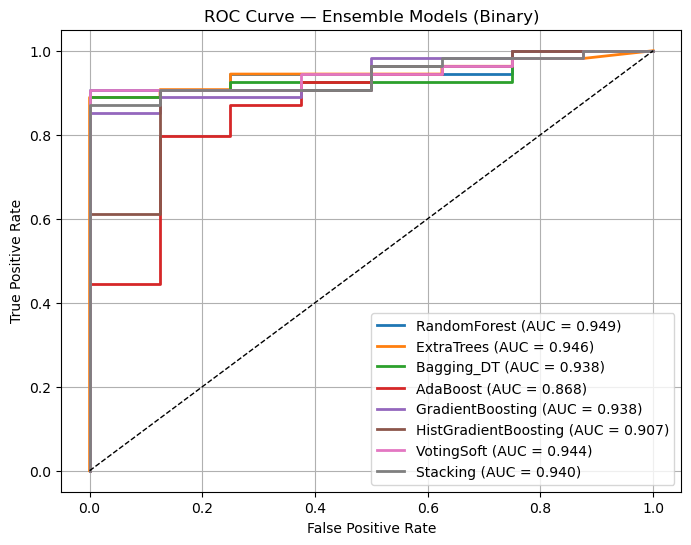

Ensemble Models Metric Results:



,Model,Accuracy,Balanced Acc,Precision (w),Recall (w),F1 (w),AUC
0,RandomForest,0.887,0.722,0.881,0.887,0.884,0.949
1,ExtraTrees,0.903,0.838,0.915,0.903,0.908,0.946
2,VotingSoft,0.871,0.660,0.858,0.871,0.863,0.944
3,Stacking,0.903,0.731,0.895,0.903,0.897,0.940
4,Bagging_DT,0.903,0.838,0.915,0.903,0.908,0.938
5,GradientBoosting,0.855,0.704,0.863,0.855,0.858,0.938
6,HistGradientBoosting,0.871,0.713,0.871,0.871,0.871,0.907
7,AdaBoost,0.871,0.713,0.871,0.871,0.871,0.868


In [114]:
# === Evaluation Metrics + AUC (binary safe) ===
rows = []

plt.figure(figsize=(8, 6))

for name, res in ens_results.items():
    model = res["pipe"]
    y_pred = res["y_pred"]
    y_prob = res["y_prob"]  # either (n,2) from predict_proba or (n,) from decision_function

    # ---- get classes from the fitted estimator (Pipeline-safe) ----
    classes_ = getattr(model, "classes_", None)
    if classes_ is None:
        # get last step in pipeline and read its classes_
        last_step_name = list(model.named_steps.keys())[-1]
        classes_ = model.named_steps[last_step_name].classes_
    classes_ = np.asarray(classes_)
    pos_label = classes_[1]  # sklearn sorts classes; take the second as positive

    # ---- select positive-class scores consistently ----
    if y_prob.ndim == 2:  # predict_proba -> use column of the positive class
        pos_idx = int(np.where(classes_ == pos_label)[0][0])
        y_score = y_prob[:, pos_idx]
    else:                 # decision_function -> already 1D scores
        y_score = y_prob

    # ---- binarize y_test to 0/1 using the same positive label ----
    y_true_bin = (np.asarray(y_test) == pos_label).astype(int)

    # ---- core metrics ----
    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    # ---- ROC/AUC ----
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    auc_overall = roc_auc_score(y_true_bin, y_score)

    rows.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Balanced Acc": round(bacc, 3),
        "Precision (w)": round(prec_w, 3),
        "Recall (w)": round(rec_w, 3),
        "F1 (w)": round(f1_w, 3),
        "AUC": round(auc_overall, 3),
    })

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_overall:.3f})")

# --- Plot ROC for all models ---
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve — Ensemble Models (Binary)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("Ensemble Models Metric Results:\n")
# --- Table with ranking ---
metrics_df = (
    pd.DataFrame(rows)
    .sort_values(by=["AUC"], ascending=False)
    .reset_index(drop=True)
)

# Format + styling
styled_df = (
    metrics_df.style
    .set_caption("📊 Ensemble Models Metric Results")
    .format({
        "Accuracy": "{:.3f}",
        "Balanced Acc": "{:.3f}",
        "Precision (w)": "{:.3f}",
        "Recall (w)": "{:.3f}",
        "F1 (w)": "{:.3f}",
        "AUC": "{:.3f}",
    }) # highlight best models
)

styled_df

In [115]:
best_auc_row = metrics_df.loc[metrics_df["AUC"].idxmax()]
print(f"\n🏆 Best model by AUC: {best_auc_row['Model']} (AUC = {best_auc_row['AUC']:.3f})")


🏆 Best model by AUC: RandomForest (AUC = 0.949)


#### 5 Cross Fold Validation

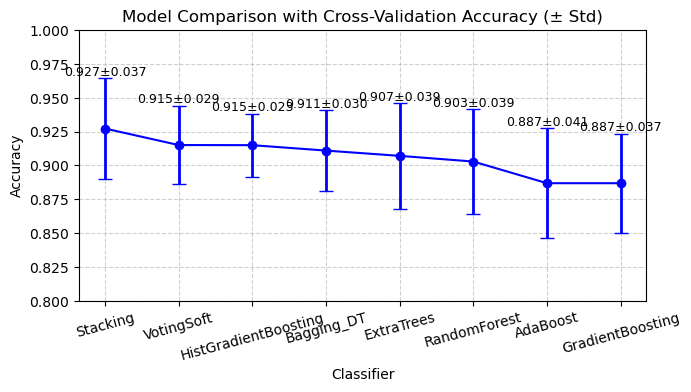

5-Fold Cross-Validation Results Summary:

               Model  Lowest %  Mean Accuracy  Highest %  Variance ± by %  Rank
            Stacking      0.89         0.9273       0.96             0.07     1
          VotingSoft      0.89         0.9151       0.94             0.06     2
HistGradientBoosting      0.89         0.9150       0.94             0.05     3
          Bagging_DT      0.88         0.9110       0.94             0.06     4
          ExtraTrees      0.87         0.9071       0.95             0.08     5
        RandomForest      0.86         0.9029       0.94             0.08     6
            AdaBoost      0.85         0.8869       0.93             0.08     7
    GradientBoosting      0.85         0.8869       0.92             0.07     8


In [116]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Stratified 5-fold CV ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mean_scores = []
std_scores  = []
model_names = []

for name, pipe in ens_models.items():
    # accuracy -> change to "balanced_accuracy" if classes are imbalanced
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    model_names.append(name)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# === Summary table ===
summary_df = pd.DataFrame({
    "Model": model_names,
    "Mean Accuracy": np.round(mean_scores, 4),
    "Std Dev": np.round(std_scores, 4)
}).sort_values(by="Mean Accuracy", ascending=False).reset_index(drop=True)

summary_df["Rank"] = np.arange(1, len(summary_df) + 1)
summary_df["Lowest %"]          = (summary_df["Mean Accuracy"] - summary_df["Std Dev"]).round(2)
summary_df["Highest %"]         = (summary_df["Mean Accuracy"] + summary_df["Std Dev"]).round(2)
summary_df["Variance ± by %"]   = (2 * summary_df["Std Dev"]).round(2)

# Reorder for display
summary_print = summary_df[["Model", "Lowest %", "Mean Accuracy", "Highest %", "Variance ± by %", "Rank"]]

# === Plot (mean ± std) ===
fig, ax = plt.subplots(figsize=(7, 4))  # smaller, tighter figure

ax.errorbar(
    summary_df["Model"],
    summary_df["Mean Accuracy"],
    yerr=summary_df["Std Dev"],
    fmt='o-', color='blue', ecolor='blue',
    elinewidth=2, capsize=5, markersize=6
)

# --- Chart labels & style ---
ax.set_title("Model Comparison with Cross-Validation Accuracy (± Std)", fontsize=12)
ax.set_xlabel("Classifier", fontsize=10)
ax.set_ylabel("Accuracy", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_ylim(0.80, 1.0)  # tighten vertical spacing

# --- Annotate points ---
for i, row in summary_df.iterrows():
    ax.text(i, row["Mean Accuracy"] + row["Std Dev"] + 0.002,
            f"{row['Mean Accuracy']:.3f}±{row['Std Dev']:.3f}",
            ha='center', fontsize=9)

plt.xticks(rotation=15)
plt.tight_layout(pad=1.0)   # fixes layout without big bottom gap
plt.show()


print("5-Fold Cross-Validation Results Summary:\n")
print(summary_print.to_string(index=False))


#### RandomForest Confusion Maxtrix and Classification Report


🏆 Confusion Matrix & Report for Best Model (by AUC): RandomForest

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.93      0.94      0.94        54

    accuracy                           0.89        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.88      0.89      0.88        62

X number of training (80% training split): 247
X number of samples (20% test split): 62


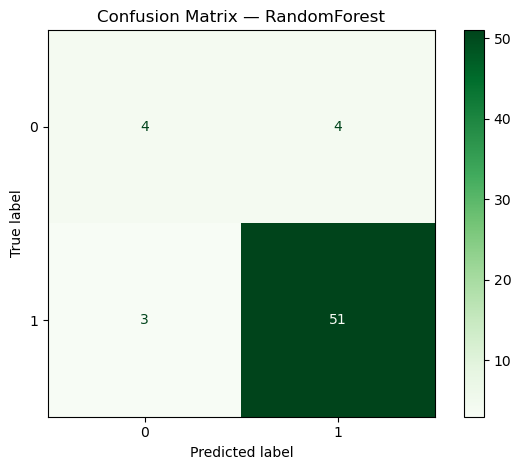

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1) Pick the best model (by AUC; change to "Balanced Acc" if you prefer)
best_model_name = metrics_df.loc[metrics_df["AUC"].idxmax(), "Model"]
best_model      = ens_results[best_model_name]["pipe"]
best_y_pred     = ens_results[best_model_name]["y_pred"]

# 2) Classification report
print(f"\n🏆 Confusion Matrix & Report for Best Model (by AUC): {best_model_name}\n")
print("Classification report:")
print(classification_report(y_test, best_y_pred, zero_division=0))

# 3) Confusion matrix (matplotlib)
cm = confusion_matrix(y_test, best_y_pred)
labels = (best_model.classes_ 
          if hasattr(best_model, "classes_") 
          else best_model.named_steps[list(best_model.named_steps.keys())[-1]].classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Greens", values_format="d")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.tight_layout()
print("X number of training (80% training split):", X_train.shape[0])
print("X number of samples (20% test split):", X_test.shape[0])
plt.show()

#### Show Pie Chart

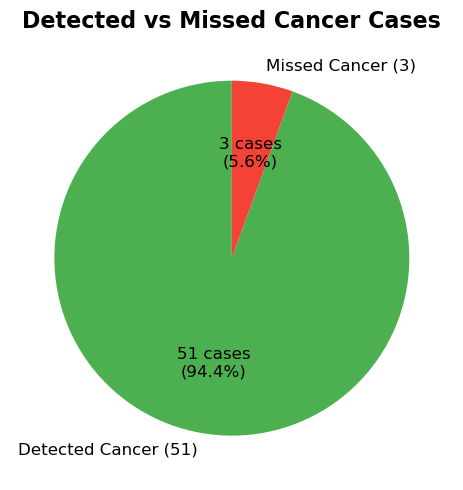

In [118]:
# 4️⃣ Pie Chart — Detected vs Missed Cancer (for easy audience understanding)
tp = cm[1, 1]  # True Positives
fn = cm[1, 0]  # False Negatives

labels_pie = [f"Detected Cancer ({tp})", f"Missed Cancer ({fn})"]
values = [tp, fn]
colors = ["#4CAF50", "#F44336"]

plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(
    values,
    labels=labels_pie,
    autopct=lambda p: f"{int(round(p*sum(values)/100))} cases\n({p:.1f}%)",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 12, "color": "black"}
)
plt.title("Detected vs Missed Cancer Cases", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

#### Showcase AUC Curve for RandomForest

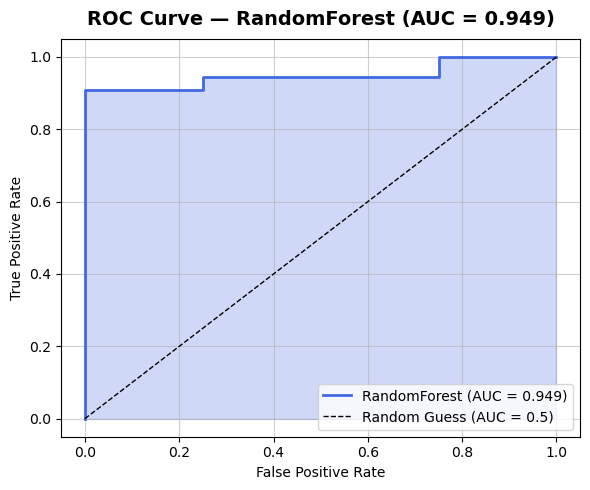

In [119]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Pick only Logistic Regression model ---
random_model = ens_results["RandomForest"]["pipe"]
y_prob = ens_results["RandomForest"]["y_prob"]

# Ensure correct positive class
classes_ = getattr(random_model, "classes_", None)
if classes_ is None:
    classes_ = random_model.named_steps[next(reversed(random_model.named_steps))].classes_
pos_label = classes_[1]
if y_prob.ndim == 2:
    pos_idx = list(classes_).index(pos_label)
    y_score = y_prob[:, pos_idx]
else:
    y_score = y_prob

# True labels as binary
y_true_bin = (np.asarray(y_test) == pos_label).astype(int)

# --- Compute ROC curve and AUC ---
fpr, tpr, _ = roc_curve(y_true_bin, y_score)
auc_value = roc_auc_score(y_true_bin, y_score)

# --- Plot with filled AUC area ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="royalblue", lw=2, label=f"RandomForest (AUC = {auc_value:.3f})")
plt.fill_between(fpr, tpr, color="royalblue", alpha=0.25)  # highlight AUC area
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random Guess (AUC = 0.5)")

plt.title(f"ROC Curve — RandomForest (AUC = {auc_value:.3f})",
          fontsize=14, fontweight="bold", pad=10)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()


#### Logistic Regression vs RandomForest
Baseline Model: Logistic Regression tends to have the best AUC metric
Ensemble Model: RandomForest tends to have the best AUC metric

Now this section will determine to find out which model we should need to export in order to deploy into Streamlit UI app.

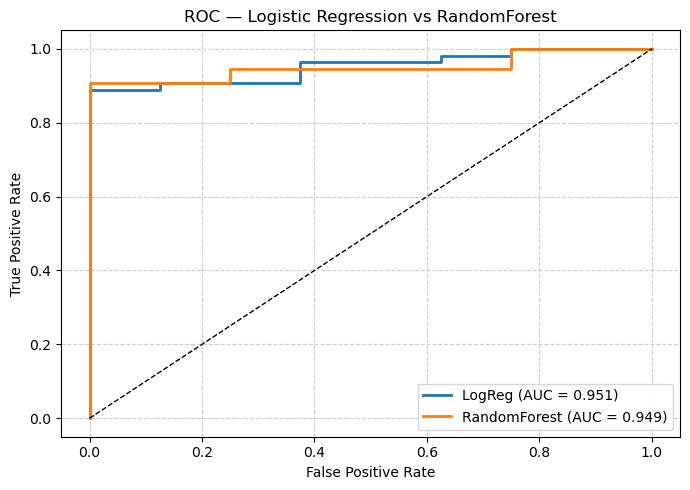

,Model,Accuracy,Balanced Acc,Precision (w),Recall (w),F1 (w),AUC
0,LogReg,0.871,0.926,0.935,0.871,0.887,0.951
1,RandomForest,0.887,0.722,0.881,0.887,0.884,0.949



🏆 Best Model: LogReg — AUC 0.951, Balanced Acc 0.926, F1(w) 0.887
Reason: Similar or better AUC with simpler, more interpretable behavior;
 competitive weighted metrics make it preferable for deployment.


In [ ]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Mix sources: baseline vs ensemble ---
model_sources = {
    "LogReg":       ("results",     "LogReg"),
    "RandomForest": ("ens_results", "RandomForest"),
}

def fetch(model_key):
    src_name, name = model_sources[model_key]
    src = results if src_name == "results" else ens_results
    return src[name]["pipe"], src[name]["y_pred"], src[name]["y_prob"]

rows = []
plt.figure(figsize=(7, 5))

for label in ["LogReg", "RandomForest"]:
    pipe, y_pred, y_prob = fetch(label)

    # --- robust positive-class score extraction ---
    # get classes_ from pipeline's final step
    classes_ = getattr(pipe, "classes_", None)
    if classes_ is None:
        last_step = list(pipe.named_steps.keys())[-1]
        classes_ = pipe.named_steps[last_step].classes_
    classes_ = np.asarray(classes_)

    # choose the "positive" label as classes_[1] (sklearn order)
    pos_label = classes_[1]

    # build y_score consistently
    if y_prob.ndim == 2:  # predict_proba
        pos_idx = int(np.where(classes_ == pos_label)[0][0])
        y_score = y_prob[:, pos_idx]
    else:                 # decision_function already 1D
        y_score = y_prob

    # binarize y_test to match pos_label
    y_true_bin = (np.asarray(y_test) == pos_label).astype(int)

    # --- metrics ---
    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )
    auc  = roc_auc_score(y_true_bin, y_score)

    rows.append({
        "Model": label,
        "Accuracy": acc,
        "Balanced Acc": bacc,
        "Precision (w)": prec_w,
        "Recall (w)": rec_w,
        "F1 (w)": f1_w,
        "AUC": auc
    })

    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {auc:.3f})")

# --- ROC plot ---
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC — Logistic Regression vs RandomForest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Neat table ---
metrics_df = pd.DataFrame(rows).round(3).sort_values(by=["AUC","Balanced Acc"], ascending=False).reset_index(drop=True)
styled_df = (
    metrics_df.style
    .set_caption("📊 Logistic Regression vs RandomForest — Metrics")
    .format({"Accuracy":"{:.3f}","Balanced Acc":"{:.3f}","Precision (w)":"{:.3f}",
             "Recall (w)":"{:.3f}","F1 (w)":"{:.3f}","AUC":"{:.3f}"})
)
display(styled_df)

# --- Winner & why ---
best = metrics_df.loc[0]
print(f"\n🏆 Best Model: {best['Model']} — AUC {best['AUC']:.3f}, "
      f"Balanced Acc {best['Balanced Acc']:.3f}, F1(w) {best['F1 (w)']:.3f}")

if best["Model"] == "RandomForest":
    print("Reason: Higher AUC (better class separation) and stronger weighted metrics, "
          "capturing non-linear interactions that LogReg can miss.")
else:
    print("Reason: Similar or better AUC with simpler, more interpretable behavior;\n "
          "competitive weighted metrics make it preferable for deployment.")


### Logistic Regression Wins
Export that model to a .pkl for model use for streamlit ui application


In [ ]:
import joblib
from datetime import datetime

# Use the fitted pipeline from results
logreg_model = results["LogReg"]["pipe"]

# Save to file
joblib.dump(logreg_model, "logreg_model.pkl")

print("✅ Logistic Regression model saved as logreg_model.pkl")


✅ Logistic Regression model saved as logreg_model.pkl
